In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_Annealing")' SchwiftyNotebook_Annealing

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_Annealing")
		SchwiftyNotebook_Annealing
With SwiftPM flags: []
Working in: /tmp/tmpdgqbdsxf/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information availabl

In [2]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_Annealing

## Model


In [3]:
//export
public struct HyperParameters {
    public let learningRate: Float
}

In [4]:
//export
public protocol TeachableModel {
    
    func apply(inputTensor: TensorFloat) -> TensorFloat
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel)
    
    func backwardsPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> TeachableModel    
}

In [5]:
//export
public protocol ModelParameterV2  {
    
    func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2)
    
    func apply(_ inputTensor: TensorFloat) -> TensorFloat 
    
    func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> (TensorFloat, ModelParameterV2)
}

In [6]:
//export
public struct DenseLayerV2: ModelParameterV2 {
    let activationFunction: SingleInputDifferentiable<TensorFloat>
    let weightParameter: TensorFloat
    let biasParameter: TensorFloat
    private let gradientChain: ThreeInputGradient

    private init(activationFunction: @escaping SingleInputDifferentiable<TensorFloat>,
                 weightParameter: TensorFloat,
                 biasParameter: TensorFloat,
                 gradientChain: @escaping ThreeInputGradient) {
        self.activationFunction = activationFunction
        self.weightParameter = weightParameter
        self.biasParameter = biasParameter
        self.gradientChain = gradientChain
    }

    private init(denseLayer: DenseLayerV2,
                 gradientChain: @escaping ThreeInputGradient) {
        self.activationFunction = denseLayer.activationFunction
        self.weightParameter = denseLayer.weightParameter
        self.biasParameter = denseLayer.biasParameter
        self.gradientChain = gradientChain
    }

    public init(inputSize: Int,
         outputSize: Int,
         activationFunction: @escaping SingleInputDifferentiable<TensorFloat> = identititySVGC){
        self.activationFunction = activationFunction
        self.weightParameter = TensorFloat(kaimingUniform: TensorShape([inputSize, outputSize]))
        self.biasParameter = TensorFloat(zeros: [outputSize])
        self.gradientChain = { (x: TensorFloat)  in (TensorFloat([1]), TensorFloat([1]), TensorFloat([1]))}
    }

    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, ModelParameterV2) {
        let (parameterOutput, parameterGradientChain) =
          linearCombinationAndGradient(inputTensor: inputTensor,
                                       weightParameter: self.weightParameter,
                                       biasParameter: self.biasParameter)
        
        let (activations, activationsGradientChain) = activationFunction(parameterOutput)

        return (activations, DenseLayerV2(denseLayer: self,
                                       gradientChain: {ddx in parameterGradientChain(activationsGradientChain(ddx))}))
    }

    public func apply(_ inputTensor: TensorFloat) -> TensorFloat {
        let parameterOutput =
          linearCombination(inputs: inputTensor,
                                       weights: self.weightParameter,
                                       bias: self.biasParameter)
        let (activations, activationsGradientChain) = activationFunction(parameterOutput)
        return activations
    }

    public func backwardPass(ddx: TensorFloat, hyperParameters: HyperParameters) -> 
    (TensorFloat, ModelParameterV2) {
        let (ddxInput, ddxParameter, ddxBias) = self.gradientChain(ddx)
        return (ddxInput, DenseLayerV2(activationFunction: activationFunction,
                                    weightParameter: self.weightParameter - hyperParameters.learningRate * ddxParameter,
                                    biasParameter: self.biasParameter - hyperParameters.learningRate * ddxBias,
                                    gradientChain: self.gradientChain))
    }
}



In [7]:
struct SimpleModel : TeachableModel {
    
    private let denseLayer: ModelParameterV2
    
    private init(denseLayer: ModelParameterV2){
        self.denseLayer = denseLayer
    }
    
    public init(inputSize: Int, 
                numberOfClasses: Int) {
        self.denseLayer = DenseLayerV2(inputSize: inputSize, outputSize: numberOfClasses)
    }
    
    public func apply(inputTensor: TensorFloat) -> TensorFloat {
        return self.denseLayer.apply(inputTensor)
    }
    
    public func forwardPass(inputTensor: TensorFloat) -> (TensorFloat, TeachableModel) {
        let (activations, newDenseLayer) = self.denseLayer.forwardPass(inputTensor: inputTensor)
        return (activations, SimpleModel(denseLayer: newDenseLayer))
    }
    
    public func backwardsPass(ddx: TensorFloat, 
                              hyperParameters: HyperParameters) -> TeachableModel {
        let (ddxDenseLayer, optimizedDenseLayer) = self.denseLayer.backwardPass(ddx: ddx, 
                                                          hyperParameters: hyperParameters)
        return SimpleModel(denseLayer: optimizedDenseLayer)
    }
}

## Data

In [8]:
//export
public struct DataBunch<T> where T: TensorGroup {
    public let trainingDataset: Dataset<T>
    public let validationDataset: Dataset<T>
}

In [9]:
// export
public struct SupervisedLearningGroup {
    let features: TensorFloat
    let labels: TensorFloat
}

extension SupervisedLearningGroup: TensorGroup {
    
    public static var _typeList: [TensorDataType] = [
        Float.tensorFlowDataType,
        Float.tensorFlowDataType
    ]
    public static var _unknownShapeList: [TensorShape?] = [nil, nil]
    public var _tensorHandles: [_AnyTensorHandle] {
        fatalError("unimplemented")
    }
    public func _unpackTensorHandles(into address: UnsafeMutablePointer<CTensorHandle>?) {
        address!.advanced(by: 0).initialize(to: features.handle._cTensorHandle)
        address!.advanced(by: 1).initialize(to: labels.handle._cTensorHandle)
    }
    public init(_owning tensorHandles: UnsafePointer<CTensorHandle>?) {
        features = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 0).pointee))
        labels = Tensor(handle: TensorHandle(_owning: tensorHandles!.advanced(by: 1).pointee))
    }
    public init<C: RandomAccessCollection>(_handles: C) where C.Element: _AnyTensorHandle {
        fatalError("unimplemented")
    }
}

public extension Sequence where Element == SupervisedLearningGroup {
    var first: SupervisedLearningGroup? {
        return first(where: { _ in true })
    }
}

public extension Dataset where Element == SupervisedLearningGroup {
    init(featuresTensor: TensorFloat, labelsTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(
                                                    features: featuresTensor, 
                                                    labels: labelsTensor.expandingShape(at: 1)))
    }
}

In [10]:
import Python


## Teach

In [11]:
//export 
public protocol TeachingDelegate {
    
    func preTeach(epochs: Int)
    
    func postTeach()
    
    func preEpoch(epochNumber: Int, dataSet: Dataset<SupervisedLearningGroup>)
    
    func postEpoch(epochNumber: Int)
    
    func processBatch(model: TeachableModel, 
                      xDataPoints: TensorFloat,
                      yValidationPoints: TensorFloat) -> TeachableModel    
}

In [12]:
//export
public struct Teacher {
    
    private let dataBunch: DataBunch<SupervisedLearningGroup>
    private let trainingDelegate: TeachingDelegate
    private let validationDelegate: TeachingDelegate
    
    
    public func teachModel(model: TeachableModel,
                           numberOfEpochs: Int) -> TeachableModel {
        notifyPreTeach(epochs: numberOfEpochs)
        let taughtModel = (1...numberOfEpochs)
            .reduce(into: model) { (currentModel: inout TeachableModel, 
                                    epoch: Int) in
                let trainedModel = trainModel(modelToTeach: currentModel,
                                              currentEpoch: epoch)
                currentModel = validateModel(modelToValidate: trainedModel,
                                             currentEpoch: epoch)
            }
        notifyPostTeach()
        return taughtModel
    }
    
    private func trainModel(modelToTeach: TeachableModel, 
                            currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToTeach,
                           epoch: currentEpoch,
                           dataSet: dataBunch.trainingDataset,
                           teachingDelegate: trainingDelegate)
    }
    
    private func validateModel(modelToValidate: TeachableModel, 
                               currentEpoch: Int) -> TeachableModel {
        return processDataSet(model: modelToValidate,
                              epoch: currentEpoch,
                              dataSet: dataBunch.validationDataset,
                              teachingDelegate: validationDelegate)
    }
    
    private func processDataSet(model: TeachableModel,
                             epoch: Int,
                             dataSet: Dataset<SupervisedLearningGroup>,
                             teachingDelegate: TeachingDelegate
                            ) -> TeachableModel {
        
        teachingDelegate.preEpoch(epochNumber: epoch, 
                                  dataSet: dataSet)
        
        let taughtModel: TeachableModel = dataSet.reduce(into: model) {
            (currentModel: inout TeachableModel, dataGroup: SupervisedLearningGroup) in
            currentModel = teachingDelegate.processBatch(model: currentModel, 
                                                         xDataPoints: dataGroup.features, 
                                                         yValidationPoints: dataGroup.labels)
        }
        
        teachingDelegate.postEpoch(epochNumber: epoch)
        
        return taughtModel
    }
    
    
    private func notifyPreTeach(epochs: Int) {
        trainingDelegate.preTeach(epochs: epochs)
        validationDelegate.preTeach(epochs: epochs)
    }
    
    private func notifyPostTeach() {
        trainingDelegate.postTeach()
        validationDelegate.postTeach()
    }
}

## Teaching Delegates

In [13]:
//export
public protocol LossFunction {
    func lossAndGradient(expectedTensor: TensorFloat,
                         actualTensor: TensorFloat) -> (loss: TensorFloat,
                                                        gradientSupplier: () -> TensorFloat)
    func calculateLoss(expectedTensor: TensorFloat,
                       actualTensor: TensorFloat) -> TensorFloat
}

In [14]:
class ValidationDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    
    public init(lossFunction: LossFunction) {
        self.lossFunction = lossFunction
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches)
        print("Validation Loss for Epoch #\(epochNumber): \(loss)")
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let predictions = model.apply(inputTensor: xDataPoints)
        
        let loss = lossFunction.calculateLoss(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictions)
        totalLoss += loss
        numberOfBatches += 1
        
        return model
    }
    
}

In [15]:
class TrainingDelegate: TeachingDelegate {
    
    let lossFunction: LossFunction
    
    public init(lossFunction: LossFunction) {
        self.lossFunction = lossFunction
    }
    
    private var epochNumber: Int = 0
    private var numberOfBatches: Int = 0
    private var totalLoss: TensorFloat = TensorFloat([0.0])
    
    public func postEpoch(epochNumber: Int) {
        let loss = totalLoss / Float(numberOfBatches)
        print("Training Loss for Epoch #\(epochNumber): \(loss)")
    }
    
    public func preEpoch(epochNumber: Int, 
                         dataSet: Dataset<SupervisedLearningGroup>) {
        numberOfBatches = 0
        totalLoss = TensorFloat([0.0])
    }
    
    public func preTeach(epochs: Int) {
    
    }
    
    public func postTeach() {
    
    }
    
    
    public func processBatch(model: TeachableModel, 
                             xDataPoints: TensorFloat, 
                             yValidationPoints: TensorFloat) -> TeachableModel {

        let (predictions, modelWithChain) = model.forwardPass(inputTensor: xDataPoints)
        
        let (lossyBoi, predictionGradientSupplier) = lossFunction.lossAndGradient(expectedTensor: yValidationPoints, 
                                                                    actualTensor: predictions)
        
        totalLoss += lossyBoi
        numberOfBatches += 1
        
        // todo: Optimize Hyper Parameters beforehand
        let hyperParameters = HyperParameters(learningRate: 1e-2)
        
        return modelWithChain.backwardsPass(ddx: predictionGradientSupplier(),
                                            hyperParameters: hyperParameters)
    }
    
}

In [16]:
//export
public struct MeanSquaredErrorLossFunction: LossFunction {
        
    public func calculateLoss(expectedTensor: TensorFloat, 
                              actualTensor: TensorFloat) -> TensorFloat {
        let error: TensorFloat = calculateError(expectedTensor: expectedTensor,
                                   actualTensor: actualTensor)
        return error.squared().mean()
    }
    
    public func lossAndGradient(expectedTensor: TensorFloat, 
                                actualTensor: TensorFloat) -> (loss: TensorFloat, gradientSupplier: () -> TensorFloat) {
        let error = calculateError(expectedTensor:expectedTensor, 
                                   actualTensor: actualTensor)
        let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
        let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)

        return (loss: meanValue, gradientSupplier: { squareGradient(meanGradient(TensorFloat([1]))) })
    }
    
    private func calculateError(expectedTensor: TensorFloat,
                                actualTensor: TensorFloat) -> TensorFloat {
        assert(expectedTensor.shape == actualTensor.shape, "Expected \(expectedTensor.shape) to be the same as \(actualTensor.shape)")
        return expectedTensor - actualTensor
    }
}

## Point Data Trials

In [17]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [18]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


In [19]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [20]:
public let plotter = Python.import("matplotlib.pyplot")

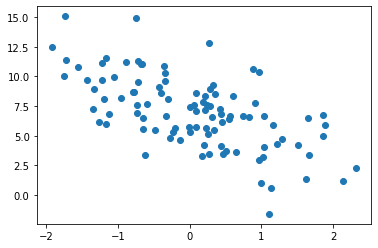

None


In [21]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()

In [22]:
func showYHat(yHat: TensorFloat) {
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
    plotter.show()
}

In [23]:
let linearModel = SimpleModel(inputSize: 2, 
                              numberOfClasses: 1)
linearModel

▿ SimpleModel
  ▿ denseLayer : DenseLayerV2
    - activationFunction : (Function)
    - weightParameter : [[ -1.0922749],
 [-0.22838056]]
    - biasParameter : [0.0]
    - gradientChain : (Function)


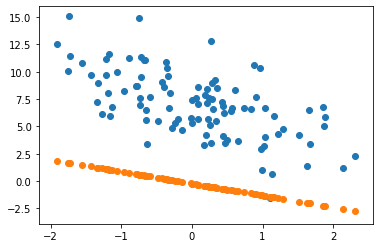

In [24]:
showYHat(yHat: linearModel.apply(inputTensor: A))

In [25]:
//export
public extension Dataset where Element == SupervisedLearningGroup {
    init(featureTensor: TensorFloat, labelTensor: TensorFloat) {
        self.init(elements: SupervisedLearningGroup(features: featureTensor, 
                                     labels: labelTensor))
    }
}

In [26]:
let linearDataSet = Dataset(featureTensor: A, labelTensor: yValidationPoints).batched(100)
let linearDataBunch = DataBunch(trainingDataset: linearDataSet,
                               validationDataset: linearDataSet)

In [27]:
let meanSquaredLossFunction = MeanSquaredErrorLossFunction()
let simpleTrainingDelegate = TrainingDelegate(lossFunction: meanSquaredLossFunction)
let simpleValidationDelegate = ValidationDelegate(lossFunction: meanSquaredLossFunction)

In [28]:
let linearTeacher = Teacher(dataBunch: linearDataBunch, 
                            trainingDelegate: simpleTrainingDelegate, 
                            validationDelegate: simpleValidationDelegate)

In [29]:
let taughtLinearModel = linearTeacher.teachModel(model: linearModel, 
                                                 numberOfEpochs: 20)

Training Loss for Epoch #1: [59.67972]
Validation Loss for Epoch #1: [64.04552]
Training Loss for Epoch #2: [64.04552]
Validation Loss for Epoch #2: [68.76612]
Training Loss for Epoch #3: [68.76612]
Validation Loss for Epoch #3: [73.87045]
Training Loss for Epoch #4: [73.87045]
Validation Loss for Epoch #4: [79.38982]
Training Loss for Epoch #5: [79.38982]
Validation Loss for Epoch #5: [85.35805]
Training Loss for Epoch #6: [85.35805]
Validation Loss for Epoch #6: [91.811775]
Training Loss for Epoch #7: [91.811775]
Validation Loss for Epoch #7: [98.79057]
Training Loss for Epoch #8: [98.79057]
Validation Loss for Epoch #8: [106.33729]
Training Loss for Epoch #9: [106.33729]
Validation Loss for Epoch #9: [114.498245]
Training Loss for Epoch #10: [114.498245]
Validation Loss for Epoch #10: [123.32358]
Training Loss for Epoch #11: [123.32358]
Validation Loss for Epoch #11: [132.86748]
Training Loss for Epoch #12: [132.86748]
Validation Loss for Epoch #12: [143.18857]
Training Loss for Epo

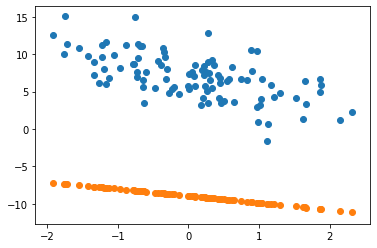

In [30]:
showYHat(yHat: taughtLinearModel.apply(inputTensor: A))